In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# color dict (use: colors['XColor'])

colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

# MLL and Scikit Results

In [3]:
burn = pd.read_csv('~/learn-me-fuel/results/19jan2020_15nuc/15nuc_m60_scale-last_burnup_random-error.csv')
rxtr = pd.read_csv('~/learn-me-fuel/results/19jan2020_15nuc/15nuc_m60_scale-last_reactor_random-error.csv')
cool = pd.read_csv('~/learn-me-fuel/results/19jan2020_15nuc/15nuc_m60_scale-last_cooling_random-error.csv')

In [4]:
rxtr.head()

,Unnamed: 0,Percent Error,kNN Score,kNN Std,DTree Score,DTree Std,SVR Score,SVR Std
0,0.0,0.0,0.973450,0.005838,0.965552,0.006219,0.996303,0.00247
1,0.1,0.1,0.971601,0.006185,0.963198,0.006259,0.996303,0.00247
2,0.2,0.2,0.972105,0.005686,0.963703,0.004831,0.996303,0.00247
3,0.3,0.3,0.972273,0.005499,0.960846,0.009049,0.996303,0.00247
4,0.4,0.4,0.972273,0.005395,0.960845,0.008130,0.996135,0.00247


In [5]:
results_path = '~/sims_n_results/nucmoles_opusupdate_aug2019/'
tamuNoRatio_path = results_path + 'tamuNoRatio/'
tamuRatio_path = results_path + 'tamuRatio/'
sfco_path = results_path + 'sfco/'
# Copied from scripts
uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
dfs = {}
for i, unc_job in enumerate(job_dirs):
    dfs['dfTamu' + str(i)] = pd.read_csv(tamuNoRatio_path + unc_job + '/' + unc_job + '.csv')
    dfs['dfTamuRatio' + str(i)] = pd.read_csv(tamuRatio_path + unc_job + '/' + unc_job + '.csv')
    dfs['dfSfco' + str(i)] = pd.read_csv(sfco_path + unc_job + '/' + unc_job + '.csv')
dfs.keys()

dict_keys(['dfTamu0', 'dfTamuRatio0', 'dfSfco0', 'dfTamu1', 'dfTamuRatio1', 'dfSfco1', 'dfTamu2', 'dfTamuRatio2', 'dfSfco2', 'dfTamu3', 'dfTamuRatio3', 'dfSfco3'])

In [6]:
dfs['dfSfco1'].columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'sim_idx', 'ReactorType', 'CoolingTime',
       'Enrichment', 'Burnup', 'OrigenReactor', 'pred_idx', 'pred_ReactorType',
       'pred_CoolingTime', 'pred_Enrichment', 'pred_Burnup',
       'pred_OrigenReactor', 'MaxLogLL', 'MaxLLUnc', '2ndMaxLogLL',
       '2ndMaxLLUnc', 'CDF_LogLL_0.9998', 'CDF_LLUnc_0.9998',
       'CDF_LogLL_0.9988', 'CDF_LLUnc_0.9988', 'CDF_LogLL_0.95',
       'CDF_LLUnc_0.95', 'CDF_LogLL_0.9', 'CDF_LLUnc_0.9', 'CDF_LogLL_0.5',
       'CDF_LLUnc_0.5', 'CDF_LogLL_0.1', 'CDF_LLUnc_0.1', 'CDF_LogLL_0.01',
       'CDF_LLUnc_0.01', 'ReactorType_Score', 'CoolingTime_Error',
       'Enrichment_Error', 'Burnup_Error', 'OrigenReactor_Score'],
      dtype='object')

# Processing MLL Results

In [110]:
l1 = dfs['dfTamu3']['CoolingTime_Error']
l2 = dfs['dfTamu3']['CoolingTime']
l1, l2 = zip(*((x, y) for x, y in zip(l1, l2) if y != 0))
#len(dfs['dfTamu3']['CoolingTime']) - np.count_nonzero(dfs['dfTamu3']['CoolingTime'])
np.count_nonzero(l2)

21936

In [95]:
def score(error, y_true):
    zero_cnt = len(y_true) - np.count_nonzero(y_true)
    if zero_cnt > 0:
        error, y_true = zip(*((e, y) for e, y in zip(error, y_true) if y != 0))
        error = np.array(error)
        y_true = np.array(y_true)
    return 1 - np.mean(error / y_true)

In [98]:
tamu_rxtr = []
ratio_rxtr = []
tamu_burn = []
ratio_burn = []
tamu_cool = []
ratio_cool = []
for i, unc_job in enumerate(job_dirs):
    tamu = dfs['dfTamu' + str(i)][['ReactorType_Score', 'Burnup', 'Burnup_Error', 'CoolingTime', 'CoolingTime_Error']]
    ratio = dfs['dfTamuRatio' + str(i)][['ReactorType_Score', 'Burnup', 'Burnup_Error', 'CoolingTime', 'CoolingTime_Error']]
    tamu_rxtr.append(tamu['ReactorType_Score'].sum() / len(tamu['ReactorType_Score']))
    ratio_rxtr.append(ratio['ReactorType_Score'].sum() / len(ratio['ReactorType_Score']))
    tamu_burn.append(score(tamu['Burnup_Error'], tamu['Burnup']))
    ratio_burn.append(score(ratio['Burnup_Error'], ratio['Burnup']))
    tamu_cool.append(score(tamu['CoolingTime_Error'], tamu['CoolingTime']))
    ratio_cool.append(score(ratio['CoolingTime_Error'], ratio['CoolingTime']))

In [99]:
tamu_cool

[0.4275470499734636,
 0.2835502864275834,
 -2.1744422407960156,
 -5.310148617358728]

# Plotting

In [104]:
def plot_errorcurves(df, title):
    # Scikit Results
    err = df['Percent Error']
    knn_mean = df['kNN Score']
    knn_std = df['kNN Std']
    dtr_mean = df['DTree Score']
    dtr_std = df['DTree Std']
    svr_mean = df['SVR Score']
    svr_std = df['SVR Std']
    
    plt.clf()    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    
    # MLL Results
    unc = [100*x for x in uncs]
    sv_base = '../plots/randomerror_compare_'
    if 'Reactor' in title:
        tamu = tamu_rxtr
        ratio = ratio_rxtr
        sv_fig = sv_base + 'rxtr.png'
    elif 'Burnup' in title:
        tamu = tamu_burn
        ratio = ratio_burn
        sv_fig = sv_base + 'burn.png'
    else:
        tamu = tamu_cool
        ratio = ratio_cool
        sv_fig = sv_base + 'cool.png'
        ax.set_ylim(0, 1)
    
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Percent Error', fontsize=20, labelpad=15)
    ax.set_ylabel('Score', fontsize=20, labelpad=15)
    #ax.set_xlim(0, 10)
    
    ax.fill_between(err, knn_mean - knn_std, knn_mean + knn_std, color = colors['MBrwn'], alpha=0.2)
    ax.fill_between(err, dtr_mean - dtr_std, dtr_mean + dtr_std, color = colors['MTeal'], alpha=0.2)
    ax.fill_between(err, svr_mean - svr_std, svr_mean + svr_std, color = colors['MPurp'], alpha=0.2)
    
    ax.plot(err, knn_mean, 'o-', color=colors['MBrwn'], mew=0, ms=5, label="kNN")
    ax.plot(err, dtr_mean, 'o-', color=colors['MTeal'], mew=0, ms=5, label="Decision Tree")
    ax.plot(err, svr_mean, 'o-', color=colors['MPurp'], mew=0, ms=5, label="Support Vector")
    
    ax.plot(unc, tamu, 'o-', color=colors['DBrwn'], mew=0, ms=5, label="MLL Calc - 15 Isos")
    ax.plot(unc, ratio, 'o-', color=colors['DTeal'], mew=0, ms=5, label="MLL Calc - 10 Ratios")
    
    ax.tick_params(labelsize=14)
    ax.legend(loc='best')#'right', bbox_to_anchor=(1.4, 0.5))
    plt.show()
    
    fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

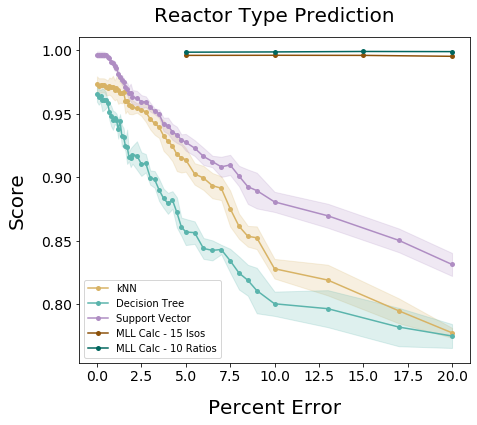

<Figure size 432x288 with 0 Axes>

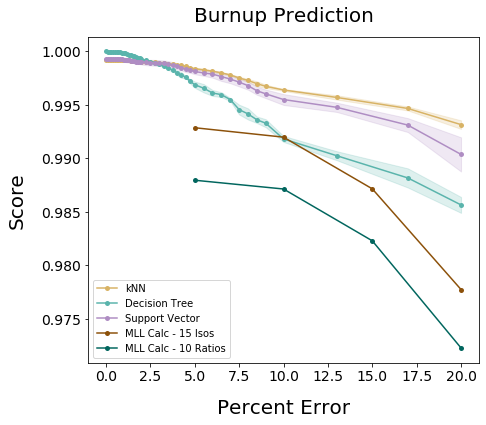

<Figure size 432x288 with 0 Axes>

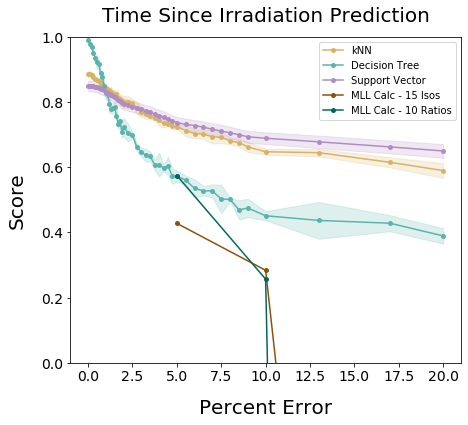

In [105]:
plot_errorcurves(rxtr, 'Reactor Type Prediction')
plot_errorcurves(burn, 'Burnup Prediction')
plot_errorcurves(cool, 'Time Since Irradiation Prediction')